In [1]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt

In [12]:
# Import the dataset and set the static variables
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

batch_size = 64
img_height = 224
img_width = 224

In [14]:
# Setting the training and validation datasets, using a split of 70% for training and 30% for validation as this is about testing the model's performance
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="training",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.3,
  subset="test",
  seed=420,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [16]:
class_names = train_ds.class_names
print(class_names)


['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


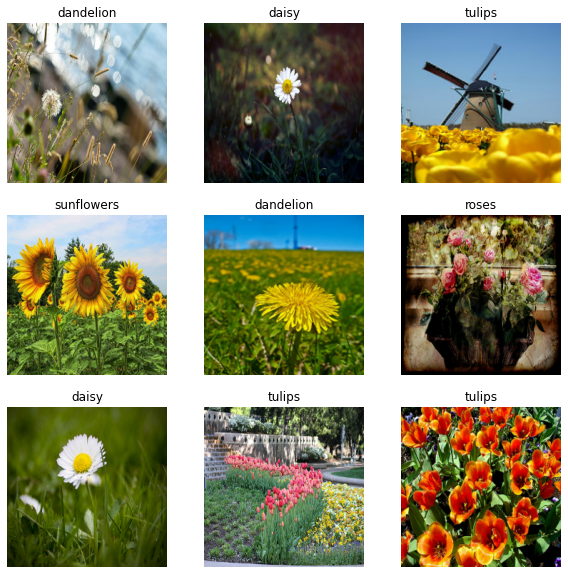

In [17]:


plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [11]:
x = tf.keras.applications.MobileNetV3Large(
    input_shape=(224, 224, 3),
    alpha=1.0,
    minimalistic=False,
    include_top=True,
    weights='imagenet',
    input_tensor=None,
    classes=1000,
    pooling=None,
    dropout_rate=0.2,
    classifier_activation='softmax',
    include_preprocessing=True
)